# Image Feature Extraction

In [ ]:
import tensorflow as tf
import os
import numpy as np
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import pandas as pd
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications.xception import Xception, preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import load_img, img_to_array
from tqdm import tqdm
import re
import pickle

2024-05-18 06:22:35.852803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 06:22:35.852921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 06:22:35.976698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import numpy as np
from transformers import AutoFeatureExtractor, DeiTForImageClassificationWithTeacher
from PIL import Image
import torch
import os
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the feature extractor and model
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-base-distilled-patch16-224')
model.eval().to(device)

image_dir = '/kaggle/input/visual-question-answering/val2014/val2014'

train_features = []
for filename in tqdm(os.listdir(image_dir)):
    image_path = os.path.join(image_dir, filename)
    img = Image.open(image_path).convert("RGB")  # Convert image to RGB if needed

    # Apply transforms and move data to GPU
    inputs = feature_extractor(images=img, return_tensors="pt").to(device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        features = logits if logits is not None else outputs.last_hidden_state
    train_features.append(features.cpu().numpy())  # Move data back to CPU and convert to numpy array

# Convert train_features to a numpy array
train_features = np.array(train_features)

# Reshape the array to (number of images, 1000)
train_features = train_features.squeeze()

print(train_features.shape)  # Should output (number_of_images, 1000)


In [ ]:
tp = list(train_features)

In [ ]:
len(tp[0])

In [ ]:
# Define paths to dataset and output files
data_dir = "/kaggle/input/visual-question-answering/"
output_dir = "/kaggle/working/"
image_dir = os.path.join(data_dir, "val2014")
output_file = os.path.join(output_dir, "val_features.npy")

# Define a data generator to preprocess the images
target_size = (299, 299)
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
generator = datagen.flow_from_directory(
    image_dir,
    target_size=target_size,
    batch_size=32,
    class_mode=None,
    shuffle=False
)

In [ ]:
# Concatenate and reshape the extracted features into a numpy array
tp = np.concatenate(tp)
tp = tp.reshape((len(generator.filenames), -1))

# Save the extracted features to a numpy file
np.save(output_file, tp)

In [ ]:
# add ids to features
img_ids = np.array([int(re.search("[0-9][0-9][0-9][0-9][0-9]+", gen).group()) for gen in generator.filenames])
image_features = {}
for i in range(len(img_ids)):
    image_features[img_ids[i]]= tp[i]

In [ ]:
# save dictionary to test_image_features.pkl file
with open('diet_val_image_features.pkl', 'wb') as fp:
    pickle.dump(image_features, fp)
    print('dictionary saved successfully to file')

# Question Encoding

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

# Load the BERT-based model
model = SentenceTransformer('bert-base-uncased')

# List of questions
#questions = ["What is the capital of France?", "Who wrote Harry Potter?", "What is the meaning of life?"]

# Encode the questions
question_embeddings = model.encode(questions)

In [ ]:
len(question_embeddings[0])

In [ ]:
with open('question_embeddings.pkl', 'wb') as fp:
    pickle.dump(question_embeddings, fp)
    print('Question_Embeddings save successfully to file')

In [ ]:
# Read dictionary pkl file
with open('/kaggle/input/bert-question-embeddings/question_embeddings.pkl', 'rb') as fp:
    question_embeddings = pickle.load(fp)
    print('successful')

successful


# Real All Files

In [ ]:
train_file_questions = '/kaggle/input/visual-question-answering/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json'
train_file_annotations = '/kaggle/input/visual-question-answering/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json'
val_file_questions = '/kaggle/input/visual-question-answering/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json'
val_file_annotations = '/kaggle/input/visual-question-answering/v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json'

with open(train_file_questions, 'r') as f:
    train_questions = json.load(f)['questions']
    f.close()

with open(train_file_annotations, 'r') as f:
    train_annotations = json.load(f)['annotations']
    f.close()

with open(val_file_questions, 'r') as f:
    val_questions = json.load(f)['questions']
    f.close()

with open(val_file_annotations, 'r') as f:
    val_annotations = json.load(f)['annotations']
    f.close()


#### read all train and validate image features with IDs from the pkl files

# Read dictionary pkl file
with open('/kaggle/input/deit-image-features/diet_train_image_features.pkl', 'rb') as fp:
    train_imgs_features = pickle.load(fp)
    print('successful')
#Read dictionary pkl file
with open('/kaggle/input/deit-image-features/diet_val_image_features.pkl', 'rb') as fp:
    val_imgs_features = pickle.load(fp)
    print('successful')

#### append validate to train features
print("Length of train_imgs_features:", len(train_imgs_features))
print("Length of val_imgs_features:", len(val_imgs_features))

#train_imgs_features = np.concatenate((train_imgs_features, val_imgs_features), axis=0)
train_imgs_features.update(val_imgs_features)

print(len(train_imgs_features))

#### append validate questions and answers to train questions and answers

# Combine the training and validation questions and annotations
train_questions += val_questions
train_annotations += val_annotations

successful
successful
Length of train_imgs_features: 82783
Length of val_imgs_features: 40504
123287


# Extract questions,answers,image_ids

In [ ]:
# Extract the questions and answers
questions = []
answers = []
features_id = []

for i in range(len(train_questions)):
    questions.append(train_questions[i]['question'])
    answers.append(train_annotations[i]['multiple_choice_answer'])
    features_id.append(train_questions[i]["image_id"])
print("Length of features_id:", len(features_id))
print("Maximum index in features_id:", max(features_id))

Length of features_id: 658111
Maximum index in features_id: 581929


# Answers to one-hot-encoding

In [ ]:
# Convert the answers to one-hot vectors
answers_tokenizer = Tokenizer()
answers_tokenizer.fit_on_texts(answers)
answer_word_index = answers_tokenizer.word_index
num_classes = len(answer_word_index)
answer_sequences = answers_tokenizer.texts_to_sequences(answers)

# Pad the answer sequences to ensure they all have the same length
max_answer_length = max(len(seq) for seq in answer_sequences)
padded_answers = pad_sequences(answer_sequences, maxlen=max_answer_length)

# Get the unique answers in the dataset and create a dictionary to map them to integer labels
unique_answers = list(set(answers))
label_map = {answer: i for i, answer in enumerate(unique_answers)}
with open('label_map_Full.pkl', 'wb') as fp:
    pickle.dump(label_map, fp)
    print('label_map save successfully to file')

# Convert the answers to integer labels and then to one-hot vectors
labels = [label_map[answer] for answer in answers]
one_hot_answers = to_categorical(labels, num_classes=len(unique_answers))

#### shape of the dataset

print(len(features_id))
print(question_embeddings.shape)
print(one_hot_answers.shape)

label_map save successfully to file
658111
(658111, 768)
(658111, 29332)


# Train,Test and Validation Split

In [ ]:
### split train into 80% train and 20% test
#### (inplace to prevent memory overflow)

split_indices = np.random.randint(low=0, high=len(features_id), size=int(len(features_id)*0.2))
split_indices = sorted(split_indices,reverse=True)

test_padded_sequences = []
padded_sequences = list(question_embeddings)
for i in split_indices:
    test_padded_sequences.append(padded_sequences.pop(i))

test_one_hot_answers = []
one_hot_answers = list(one_hot_answers)
for i in split_indices:
    test_one_hot_answers.append(one_hot_answers.pop(i))

test_features_id = []
for i in split_indices:
    test_features_id.append(features_id.pop(i))

### split 30% test into 20% test and 10% validate
#### (inplace to prevent memory overflow)

split_indices = np.random.randint(low=0, high=len(test_features_id), size=int(len(test_features_id)*0.5))
split_indices = sorted(split_indices,reverse=True)

val_padded_sequences = []
for i in split_indices:
    val_padded_sequences.append(test_padded_sequences.pop(i))

val_one_hot_answers = []
for i in split_indices:
    val_one_hot_answers.append(test_one_hot_answers.pop(i))

val_features_id = []
for i in split_indices:
    val_features_id.append(test_features_id.pop(i))
print("Length of val_features_id:", len(val_features_id))
print("Maximum index in val_features_id:", max(val_features_id))

Length of val_features_id: 65811
Maximum index in val_features_id: 581929


# LoRA Class

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class LoRALayer(Layer):
    def __init__(self, units, rank=1, alpha=1, **kwargs):
        super(LoRALayer, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.alpha = alpha
        self.scale = self.alpha / self.rank

    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                                 shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)

        self.A = self.add_weight(name='A',
                                 shape=(input_shape[-1], self.rank),
                                 initializer='random_normal',
                                 trainable=True)

        self.B = self.add_weight(name='B',
                                 shape=(self.rank, self.units),
                                 initializer='random_normal',
                                 trainable=True)

        self.b = self.add_weight(name='b',
                                 shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        original_out = tf.matmul(inputs, self.W) + self.b
        lora_out = self.scale * tf.matmul(tf.matmul(inputs, self.A), self.B)
        return original_out + lora_out

    def get_config(self):
        config = super(LoRALayer, self).get_config()
        config.update({
            'units': self.units,
            'rank': self.rank,
            'alpha': self.alpha,
        })
        return config

# Ensure the custom layer is recognized when loading the model
tf.keras.utils.get_custom_objects().update({'LoRALayer': LoRALayer})
def apply_lora(model):
    for layer in model.layers:
        if isinstance(layer, LoRALayer):
            # Ensure the LoRALayer's weights are trainable
            for weight in layer.trainable_weights:
                weight._trainable = True

# Architecture

In [ ]:
# Define the input layers
question_input = Input(shape=(768,), name='question_input')
image_input = Input(shape=(1000,), name='image_input')

# Define the dense layer for the question features
question_dense = LoRALayer(units=256, alpha=1, rank=8, name='question_dense')(question_input)
question_dense = Dropout(0.2, name='question_dropout')(question_dense)

# Define the dense layer for the image features
image_dense = LoRALayer(units=256, alpha=1, rank=8, name='image_dense')(image_input)
image_dense = Dropout(0.2, name='image_dropout')(image_dense)

# Concatenate the output from the LSTM and dense layers
concatenated = concatenate([question_dense, image_dense], name='concatenated')

dense_cnc = LoRALayer(units=512, alpha=1, rank=8, name='dense_cnc')(concatenated)
dense_cnc2 = Dense(units=256, activation='relu', name='dense_cnc2')(dense_cnc)
dense_cnc3 = LoRALayer(units=512, alpha=1, rank=8, name='dense_cnc3')(dense_cnc2)
dense_cnc4 = Dense(units=256, activation='relu', name='dense_cnc4')(dense_cnc3)

# Define the output layer for the classification
output = Dense(units=len(unique_answers), activation='softmax', name='output')(dense_cnc4)

In [ ]:
# Load the saved model
model = tf.keras.models.load_model("/kaggle/input/lora_alpha1_rank1/tensorflow2/version-1/1/Deit_Bert_Lora_alpha1_rank1.h5")
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ question_input      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_dense      │ (None, 256)       │    197,888 │ question_input[0… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense         │ (None, 256)       │    257,512 │ image_input[0][0] │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_dropout    │ (None, 256)       │          0 │ question_dense[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dropout       │ (None, 256)       │          0 │ image_dense[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated        │ (None, 512)       │          0 │ question_dropout… │
│ (Concatenate)       │                   │            │ image_dropout[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc           │ (None, 512)       │    263,680 │ concatenated[0][… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc2 (Dense)  │ (None, 256)       │    131,328 │ dense_cnc[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc3          │ (None, 512)       │    132,352 │ dense_cnc2[0][0]  │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc4 (Dense)  │ (None, 256)       │    131,328 │ dense_cnc3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 29332)     │  7,538,324 │ dense_cnc4[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,652,412 (33.01 MB)

 Trainable params: 8,652,412 (33.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Create the model
model = Model(inputs=[question_input, image_input], outputs=output)

# Apply LoRA to the model
apply_lora(model)

# Compile the model with SGD optimizer and categorical crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ question_input      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_dense      │ (None, 256)       │    205,056 │ question_input[0… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense         │ (None, 256)       │    266,304 │ image_input[0][0] │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_dropout    │ (None, 256)       │          0 │ question_dense[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dropout       │ (None, 256)       │          0 │ image_dense[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated        │ (None, 512)       │          0 │ question_dropout… │
│ (Concatenate)       │                   │            │ image_dropout[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc           │ (None, 512)       │    270,848 │ concatenated[0][… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc2 (Dense)  │ (None, 256)       │    131,328 │ dense_cnc[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc3          │ (None, 512)       │    137,728 │ dense_cnc2[0][0]  │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc4 (Dense)  │ (None, 256)       │    131,328 │ dense_cnc3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 29332)     │  7,538,324 │ dense_cnc4[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,680,916 (33.12 MB)

 Trainable params: 8,680,916 (33.12 MB)

 Non-trainable params: 0 (0.00 B)

# Data Generator for Training

In [ ]:
def data_generator(image_features, padded_questions, labels, batch_size):
        num_samples = len(labels)
        steps_per_epoch = num_samples // batch_size
        while True:
            for i in range(steps_per_epoch):
                batch_image_features = []
                for j in range(i*batch_size, (i+1)*batch_size):
                     # Check if the index is within bounds
                    if j < len(image_features):
                        batch_image_features.append(train_imgs_features[image_features[j]])
                batch_padded_questions = padded_questions[i*batch_size:(i+1)*batch_size]
                batch_labels = labels[i*batch_size:(i+1)*batch_size]
                yield (
                  (
                    tf.convert_to_tensor(batch_padded_questions, dtype=tf.float32),
                    tf.convert_to_tensor(batch_image_features, dtype=tf.float32)
                  ),
                tf.convert_to_tensor(batch_labels, dtype=tf.float32)
               )

Using (1/4)th of original data

In [ ]:
size = len(features_id)
split = size//4
fd = features_id[:split]
ps = padded_sequences[:split]
oha = one_hot_answers[:split]
size = len(val_features_id)
val_split = (size//4)
vfd = val_features_id[:val_split]
vps = val_padded_sequences[:val_split]
voha = val_one_hot_answers[:val_split]
len(voha)

16452

# Training Loop

In [ ]:
batch_size = 64
steps_per_epoch = len(oha) // batch_size

# Khởi tạo ModelCheckpoint
# checkpoint = ModelCheckpoint('xception_lstm_all_Full_80.h5', monitor='val_accuracy', save_best_only=True)
checkpoint = ModelCheckpoint('dino_lstm.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(data_generator(fd, ps ,oha,batch_size),
                        steps_per_epoch=steps_per_epoch,
                        epochs=10,
                        validation_data = data_generator(vfd,vps,voha,batch_size),
                        validation_steps = int(len(vfd)/batch_size),
                        callbacks=[checkpoint])

Epoch 1/10
   1/2056 ━━━━━━━━━━━━━━━━━━━━ 3:15:45 6s/step - accuracy: 0.0000e+00 - loss: 15.5818

I0000 00:00:1716013620.448684     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2056/2056 ━━━━━━━━━━━━━━━━━━━━ 628s 303ms/step - accuracy: 0.2260 - loss: 5.0569 - val_accuracy: 0.2471 - val_loss: 4.0461
Epoch 2/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 610s 297ms/step - accuracy: 0.2515 - loss: 3.9464 - val_accuracy: 0.2535 - val_loss: 3.8689
Epoch 3/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 610s 297ms/step - accuracy: 0.2609 - loss: 3.7780 - val_accuracy: 0.2562 - val_loss: 3.7592
Epoch 4/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 604s 294ms/step - accuracy: 0.2687 - loss: 3.6477 - val_accuracy: 0.2612 - val_loss: 3.6713
Epoch 5/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 610s 297ms/step - accuracy: 0.2751 - loss: 3.5323 - val_accuracy: 0.2625 - val_loss: 3.6015
Epoch 6/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 613s 298ms/step - accuracy: 0.2799 - loss: 3.4295 - val_accuracy: 0.2685 - val_loss: 3.5468
Epoch 7/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 610s 297ms/step - accuracy: 0.2867 - loss: 3.3391 - val_accuracy: 0.2724 - val_loss: 3.5068
Epoch 8/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 606s 295ms/step - accuracy: 0.2

# Model Save

In [ ]:
# Save the trained model
model.save("Deit_Bert_Lora_2.h5")

In [ ]:
# Extract the history dictionary
history_dict = history.history

# Convert the history dictionary to a DataFrame
history_df = pd.DataFrame(history_dict)

history_df.to_csv('training_history_deit_bert_lora2.csv', index=False)

# Display the DataFrame
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.240212,4.397769,0.247143,4.046132
1,0.254567,3.897583,0.253526,3.868928
2,0.262220,3.741914,0.256201,3.759243
3,0.269432,3.614418,0.261187,3.671286
4,0.276432,3.503168,0.262524,3.601512
5,0.281045,3.404449,0.268543,3.546765
6,0.287398,3.317303,0.272374,3.506771
7,0.292292,3.237011,0.275049,3.473887
8,0.297605,3.160373,0.273286,3.461261
9,0.303365,3.088761,0.274805,3.452444


# Comparison Plots

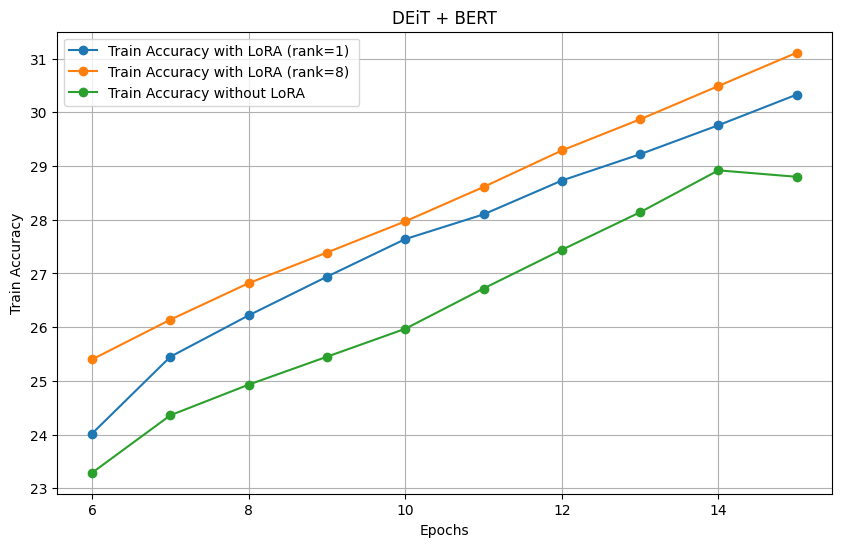

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# DataFrames for LoRA fine-tuning and without LoRA fine-tuning
data_lora_rank_1 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[24.02, 25.45, 26.22, 26.94, 27.64, 28.10, 28.73, 29.22, 29.76, 30.33],
    'val_accuracy': [24.71, 25.35, 25.62, 26.11, 26.25, 26.85, 27.23, 27.50, 27.32, 27.48]
}
df_lora_rank_1 = pd.DataFrame(data_lora_rank_1)

data_lora_rank_8 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[25.40, 26.14, 26.82, 27.39, 27.97, 28.61, 29.29, 29.87, 30.49,31.11],
    'val_accuracy': [25.37, 25.84, 26.05, 26.38, 26.87, 27.26, 27.63, 27.88, 28.06, 28.07]
}
df_lora_rank_8 = pd.DataFrame(data_lora_rank_8)


data_no_lora = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy': [23.29,24.36,24.93,25.45,25.97,26.72,27.44,28.14,28.92,28.80],
    'val_accuracy': [23.85, 23.86, 24.07, 24.26, 24.59, 25.26, 25.41, 26.13, 26.32, 26.25]
}
df_no_lora = pd.DataFrame(data_no_lora)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_lora_rank_1['epochs'], df_lora_rank_1['train_accuracy'], label='Train Accuracy with LoRA (rank=1) ', marker='o')
plt.plot(df_lora_rank_8['epochs'], df_lora_rank_8['train_accuracy'], label='Train Accuracy with LoRA (rank=8) ', marker='o')
plt.plot(df_no_lora['epochs'], df_no_lora['train_accuracy'], label='Train Accuracy without LoRA', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('DEiT + BERT')
plt.legend()
plt.grid(True)
plt.show()


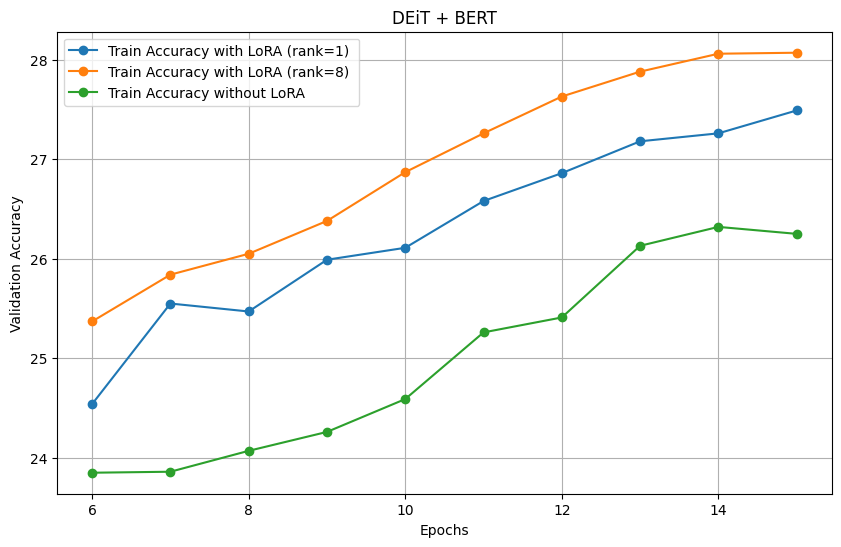

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# DataFrames for LoRA fine-tuning and without LoRA fine-tuning
data_lora_rank_1 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[26.8, 27.52, 28.27, 28.27, 28.65, 29.22, 29.98, 30.64, 31.13, 31.79],
    'val_accuracy': [24.54, 25.55, 25.47, 25.99, 26.11, 26.58, 26.86, 27.18, 27.26, 27.49]
}
df_lora_rank_1 = pd.DataFrame(data_lora_rank_1)

data_lora_rank_8 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[25.40, 26.14, 26.82, 27.39, 27.97, 28.61, 29.29, 29.87, 30.49,31.11],
    'val_accuracy': [25.37, 25.84, 26.05, 26.38, 26.87, 27.26, 27.63, 27.88, 28.06, 28.07]
}
df_lora_rank_8 = pd.DataFrame(data_lora_rank_8)


data_no_lora = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy': [23.29,24.36,24.93,25.45,25.97,26.72,27.44,28.14,28.92,28.80],
    'val_accuracy': [23.85, 23.86, 24.07, 24.26, 24.59, 25.26, 25.41, 26.13, 26.32, 26.25]
}
df_no_lora = pd.DataFrame(data_no_lora)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_lora_rank_1['epochs'], df_lora_rank_1['val_accuracy'], label='Train Accuracy with LoRA (rank=1) ', marker='o')
plt.plot(df_lora_rank_8['epochs'], df_lora_rank_8['val_accuracy'], label='Train Accuracy with LoRA (rank=8) ', marker='o')
plt.plot(df_no_lora['epochs'], df_no_lora['val_accuracy'], label='Train Accuracy without LoRA', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('DEiT + BERT')
plt.legend()
plt.grid(True)
plt.show()


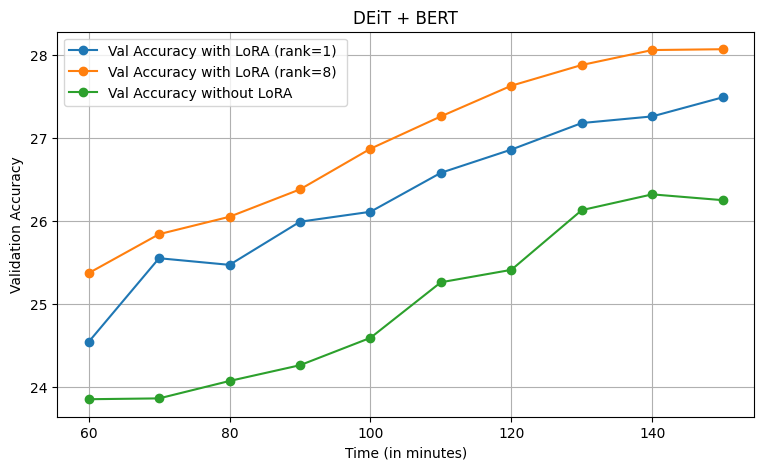

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# DataFrames for LoRA fine-tuning and without LoRA fine-tuning
data_lora_rank_1 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[26.8, 27.52, 28.27, 28.27, 28.65, 29.22, 29.98, 30.64, 31.13, 31.79],
    'val_accuracy': [24.54, 25.55, 25.47, 25.99, 26.11, 26.58, 26.86, 27.18, 27.26, 27.49]
}
df_lora_rank_1 = pd.DataFrame(data_lora_rank_1)
df_lora_rank_1['time'] = df_lora_rank_1['epochs'] * 10

data_lora_rank_8 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[25.40, 26.14, 26.82, 27.39, 27.97, 28.61, 29.29, 29.87, 30.49,31.11],
    'val_accuracy': [25.37, 25.84, 26.05, 26.38, 26.87, 27.26, 27.63, 27.88, 28.06, 28.07]
}
df_lora_rank_8 = pd.DataFrame(data_lora_rank_8)
df_lora_rank_8['time'] = df_lora_rank_8['epochs'] * 10

data_no_lora = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy': [23.29,24.36,24.93,25.45,25.97,26.72,27.44,28.14,28.92,28.80],
    'val_accuracy': [23.85, 23.86, 24.07, 24.26, 24.59, 25.26, 25.41, 26.13, 26.32, 26.25]
}
df_no_lora = pd.DataFrame(data_no_lora)
df_no_lora['time'] = df_no_lora['epochs'] * 10

# Plotting
plt.figure(figsize=(9, 5))
plt.plot(df_lora_rank_1['time'], df_lora_rank_1['val_accuracy'], label='Val Accuracy with LoRA (rank=1) ', marker='o')
plt.plot(df_lora_rank_8['time'], df_lora_rank_8['val_accuracy'], label='Val Accuracy with LoRA (rank=8) ', marker='o')
plt.plot(df_no_lora['time'], df_no_lora['val_accuracy'], label='Val Accuracy without LoRA', marker='o')

plt.xlabel('Time (in minutes)')
plt.ylabel('Validation Accuracy')
plt.title('DEiT + BERT')
plt.legend()
plt.grid(True)
plt.show()


# Testing

In [ ]:
a = data_generator(test_features_id,test_padded_sequences,test_one_hot_answers,1)

# Prediction on test data

In [ ]:
i=65811
p=[]
t=[]
while(i):
    inp,labels = next(a)
    pred = model.predict(inp)
    true_class = np.argmax(labels,axis=1)
    pred_class = np.argmax(pred,axis=1)
    p.append(pred_class)
    t.append(true_class)
    i=i-1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(t, p)
print(report)

              precision    recall  f1-score   support

          35       1.00      0.44      0.62         9
          36       0.00      0.00      0.00         0
          89       1.00      1.00      1.00         4
         110       0.00      0.00      0.00         1
         111       0.00      0.00      0.00         0
         129       0.00      0.00      0.00         1
         130       0.00      0.00      0.00         0
         174       1.00      1.00      1.00         1
         213       0.00      0.00      0.00         1
         214       0.00      0.00      0.00         0
         232       0.00      0.00      0.00         1
         233       0.00      0.00      0.00         0
         297       0.00      0.00      0.00         1
         298       0.00      0.00      0.00         0
         300       0.00      0.00      0.00         1
         301       0.00      0.00      0.00         0
         307       0.00      0.00      0.00         3
         308       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [ ]:
import pandas as pd

# Define the data
data = {
    "metrics": ["macro avg", "weighted avg"],
    "precision": [0.21, 0.82],
    "recall": [0.14, 0.26],
    "f1-score": [0.16, 0.38],
    "support": [6581, 6581]
}
print("Test Accuracy : 26%")
# Create a DataFrame
df = pd.DataFrame(data)

df

Test Accuracy : 26%


,metrics,precision,recall,f1-score,support
0,macro avg,0.21,0.14,0.16,6581
1,weighted avg,0.82,0.26,0.38,6581


In [ ]:
print("Training Accuracy : 30.28")
print("Validation Accuracy : 27.48")

Training Accuracy : 30.28
Validation Accuracy : 27.48
